# Titanic Dataset Machine Learning

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
#import training and test data

df_train = pd.read_csv(r"C:\Users\ruban\OneDrive\Documents\GitHub\Kaggle-Titanic-Competition\titanic\train.csv")
df_test = pd.read_csv(r"C:\Users\ruban\OneDrive\Documents\GitHub\Kaggle-Titanic-Competition\titanic\test.csv")

First we need to get the data into a format that will be easy for the model to process. That will involve the following:

1. Splitting the target variable from the other features
2. Join the training and test data so that you can transform all of it together. The training set has 891 rows, which we'll need to know to split the data again later.
3. Fill NaN values.
4. Normalise numerical features.
5. Convert text features into categories if possible.

In [3]:
#Feature Extraction

survived_train = df_train['Survived']
data_train = df_train.drop(['Survived'], axis=1)
data_train = pd.concat([data_train, df_test])
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


First things first, something needs to be done about the cabin column. With so many missing values I'm tempted to drop it altogether, but for now I think I'll try converting it into a binary - i.e. whether the passenger has a cabin or not.

In [4]:
data_train['Has Cabin'] = ~data_train['Cabin'].isnull()
data_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has Cabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


Next would be trying to extract something meaningful from the Name column. I can't imagine the names themselves being indicative of anything, but perhaps the title would provide some colour. We'll use regex to extract them from the column.

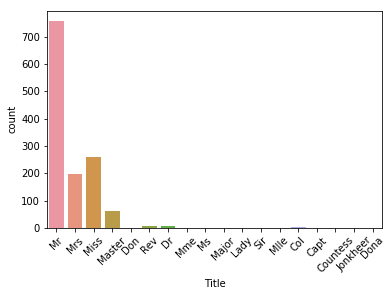

In [5]:
data_train['Title'] = data_train['Name'].apply(lambda x: re.search(' ([A-Z][a-z]+)\.',x).group(1))
sns.countplot(x='Title', data=data_train);
plt.xticks(rotation=45);

Titles can be cleaned further by combining the French titles with the english ones and grouping the rarer ones into a single 'other' category.

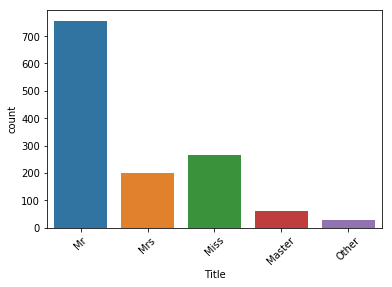

In [6]:
data_train['Title'] = data_train['Title'].replace({'Mme': 'Mrs', 'Ms': 'Miss', 'Mlle': 'Miss'})
data_train['Title'] = data_train['Title'].replace(['Don', 'Dona','Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt','Countess', 'Jonkheer'],'Other')
sns.countplot(x='Title', data=data_train);
plt.xticks(rotation=45);

In [7]:
#fill missing values. Medians for the numerical items and then the most common value for Embarked.
data_train['Age'] = data_train['Age'].fillna(data_train['Age'].median())
data_train['Fare'] = data_train['Fare'].fillna(data_train['Fare'].median())
data_train['Embarked'] = data_train['Embarked'].fillna('S')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Has Cabin      1309 non-null bool
Title          1309 non-null object
dtypes: bool(1), float64(2), int64(4), object(6)
memory usage: 174.2+ KB


Now that we have proxies for Name and Cabin, we can drop those columns. It looks like we can drop Ticket and PassengerId too as they won't add any explanatory value to the analysis. 

In [8]:
data_train.drop(['Cabin','Ticket','Name','PassengerId'], axis=1, inplace=True)

Next we need to normalise the columns with the disproportionately large values, i.e. Fare and Age. We can do this by splitting them into brackets.

In [9]:
data_train['CatAge'] = pd.qcut(data_train['Age'],q=4,labels=False)
data_train['CatFare'] = pd.qcut(data_train['Fare'],q=4, labels=False)
data_train.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Has Cabin,Title,CatAge,CatFare
413,3,male,28.0,0,0,8.0500,S,False,Mr,1,1
414,1,female,39.0,0,0,108.9000,C,True,Other,3,3
415,3,male,38.5,0,0,7.2500,S,False,Mr,3,0
416,3,male,28.0,0,0,8.0500,S,False,Mr,1,1
417,3,male,28.0,1,1,22.3583,C,False,Master,1,2


With those in place we can drop the Age and Fare columns.

Next we can combine SibSp and Parch as they're both counting families.

In [10]:
data_train = data_train.drop(['Age', 'Fare'], axis=1)
data_train['Fam_size'] = data_train['SibSp'] + data_train['Parch']
data_train = data_train.drop(['SibSp', 'Parch'], axis=1)
data_train.head()

,Pclass,Sex,Embarked,Has Cabin,Title,CatAge,CatFare,Fam_size
0,3,male,S,False,Mr,0,0,1
1,1,female,C,True,Mrs,3,3,1
2,3,female,S,False,Miss,1,1,0
3,1,female,S,True,Mrs,2,3,1
4,3,male,S,False,Mr,2,1,0


Finally we can convert the remaining columns into dummy variables...

In [11]:
data_dum = pd.get_dummies(data_train, drop_first=True)
data_dum.head()

,Pclass,Has Cabin,CatAge,CatFare,Fam_size,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0
3,1,True,2,3,1,0,0,1,0,0,1,0
4,3,False,2,1,0,1,0,1,0,1,0,0


...and split the data back into training and test sets.

In [12]:
data_ctrain = data_dum.iloc[:891]
data_ctest = data_dum.iloc[891:]

#transform into arrays
X = data_ctrain.values
test = data_ctest.values
y = survived_train.values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

Now it's time to build some classifier models. Let's start with the random forest classifier.

In [26]:
rf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [50, 100, 200, 400, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 3, 5, 7]}


rf_cv = GridSearchCV(estimator=rf,param_grid=param_grid,cv=5)

rf_cv.fit(X_train,y_train)

print(rf_cv.best_params_)

y_pred = rf_cv.predict(test)


{'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 200}


In [27]:
df_test['Survived'] = y_pred

df_test[['PassengerId', 'Survived']].to_csv(r"C:\Users\ruban\OneDrive\Documents\GitHub\Kaggle-Titanic-Competition\titanic\predictions\RFC.csv",index=False);

In [28]:
rf_cv.score(X_test, y_test)

0.8169491525423729